In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Distances;

In [2]:
#Hyperparameters
n = 10
N = 1000
σₐ = 0.001
bound = 1

k_range = 20
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] #November 3
k_list_lite = [i for i in 1:k_range]
k_real = 12
k = k_real;

In [3]:
#Functions
function plot_data(data,scores,alpha=1.0)
    scatter(data[:,1],data[:,2],c=scores)
end

mₖ(k) = k*4 + 1;

In [225]:
#Generative Classifier Network

#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, relu),
               Dense(W₂, b₂))
    return nn(x)
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

#Create a Random Network
@gen function generator(x::Array{Float64}, k=12)
    σₖ = 10.0::Float64
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    #k_real = k_list[k]
    k_real = k
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    scores = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)
    #scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    #y = @trace(mvnormal(vec(scores), Diagonal([0.001 for i=1:length(x[1,:])])), (:y))

    return scores
    
end;

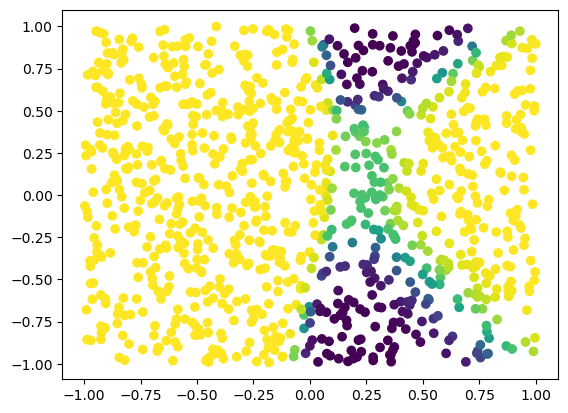

PyObject <matplotlib.collections.PathCollection object at 0x7f99d3412090>

In [229]:
#Generate Network Parameters and Corresponding Curve
obs = choicemap()::ChoiceMap
x_raw = rand(Uniform(-bound,bound),(N,2))
x = transpose(x_raw)
data = x
data_raw = x_raw

(trace,) = generate(generator, (x, k_real), obs)

Wₕ = trace[:Wₕ]
Wₒ = trace[:Wₒ]
bₕ = trace[:bₕ]
bₒ = trace[:bₒ]

y_real = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)[1,:])
#print(y_real)

y_fake = rand(Uniform(0,1),(N))
plot_data(x_raw,y_real)

In [261]:
#Classifier Network Tries to Learn the Generator Network

#@dist k_count() = categorical([1/length(k_list) for i=1:length(k_list)]) + 1

@gen function classifier(x::Array{Float64})
    σₖ = 10.0::Float64
    
    #k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    #k_real = k_list[k]
    k ~ categorical([1/length(k_list) for i=1:length(k_list)])
    k_real = k_list[k]
    #print(k)
    #k ~ k_count()
    #k_real = k
    #print(k)
    #print(k_real)
    
    #Create individual weight and bias vectors
    m = mₖ(k_real)
    h = 2*k_real
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)
    
    #Return Network Scores for X
    scores = G(x,Wₕ,bₕ,Wₒ,bₒ,k_real)
    scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([0.01 for i=1:length(x[1,:])])), (:y))
    
    return y
end;

classifier(x);

In [262]:
#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real
obs = obs_master;

obs2 = choicemap()::ChoiceMap
obs2[:y] = y_real

#println(y_real)
#println(y_fake)

(trace1,) = generate(classifier, (x,), obs)
(trace2,) = generate(classifier, (x,), obs2)

score1 = exp(get_score(trace1)/length(y_real))
score2 = exp(get_score(trace2)/length(y_real))

println(score1)
println(score2)
println(score1/score2)

#print(best_trace[:Wₕ])
#print(Wₕ)

0.004148508617887866
3.6168188952286194e-17
1.1470047956674477e14


In [260]:
print(best_pred_y)
print(y_real)

[1.0 0.9999998866927959 1.0 0.9999999999987339 0.9999995683309177 0.9999999937650723 1.0 1.0 0.9999999486171223 1.0 0.999999999996982 0.9999999999999907 0.9999999999999996 1.0 0.9999998860727607 1.0 0.9999999999999665 0.999999820789169 0.9999999999991935 1.0 0.9999999783019724 0.9999999981543986 0.9999999999959344 0.9999999957810948 0.9999999999998028 1.0 0.9999999547045311 0.999999999977728 0.9999999713255258 0.9999999414294375 0.9999997309093138 1.0 0.9999999969274767 0.9999999999999338 1.0 0.9999998524287406 0.9999999999999998 0.9999999990001462 0.9999999350480606 0.9999999999999993 0.9999999061296679 0.9999999639512314 0.999999561211196 1.0 0.9999999999731668 1.0 1.0 0.9999998588017294 0.9999999999998825 0.9999999996825812 0.9999999262959455 1.0 0.9999999999861477 0.999999999999944 1.0 0.9999999581960353 0.9999999982868011 1.0 0.9999998835447073 0.999999926110357 0.9999997835395458 0.9999997021668462 1.0 0.9999999153919761 0.999999999998149 1.0 1.0 0.9999999999595186 1.0 0.99999999

 0.9999999625798758 1.0 1.0 0.9999998813611611 0.9999999979505263 0.9999999753041168 0.9999998172100165 0.9999999129918773 1.0 1.0 0.9999999631469307 1.0 0.9999997964752932 1.0 1.0 0.9999999999488693 1.0 0.9999999999939975 0.9999999999999996 0.9999999086974011 0.9999999999999996 0.9999999917648826 0.9999998494270423 0.9999999999997122 1.0 1.0 0.9999999403678814 1.0 0.9999999999983669 0.9999999632770105 0.9999999969445601 1.0 0.9999999255715633 0.9999999802882055 0.9999997571962213 0.9999999999999991 0.9999998503430623 0.9999999486974944 1.0 0.999999893729012 0.999999923945289 0.9999999999998315 1.0 0.999999999999998 0.9999999554384484 1.0 1.0 1.0 1.0 1.0 0.9999999819002726 0.9999999526734213 1.0 1.0 0.9999999500699159 1.0 0.9999999999999942 1.0 0.9999998352717965 0.9999999999030882 0.9999999704798654 0.9999999072675151 1.0 1.0 0.9999999723862955 1.0 0.9999999999862772 1.0 0.9999999999999998 0.9999999999999996 1.0 0.9999999181784567 0.9999999217618659 1.0 1.0 0.9999999999999993 0.999999

, 1.0, 0.984598164168915, 0.9974396788190989, 0.9925866867225117, 0.9999999967344386, 0.7126338334383869, 0.9956775065339922, 0.9987401449895208, 0.32628990385818046, 1.0, 0.9504990938184603, 0.9998849394651045, 0.9999999999217473, 0.9999999497138491, 0.9999999999999993, 0.8216379091763285, 1.0, 1.0, 0.8516574276224647, 1.0, 0.9999424771087732, 0.29768067921159985, 0.02464961956585158, 1.0, 0.9706712535887518, 0.9808100825727839, 0.9879964446227372, 0.9999999999999984, 0.08029682336597302, 0.997719906088598, 1.0, 0.9653398391008272, 1.0, 1.0, 0.9999999999999964, 0.009513227284859985, 1.0, 1.0, 0.9848983588400436, 0.7071186381662288, 0.9999999999999969, 0.07092170463616926, 0.993821744627593, 0.012981065535795363, 0.989050833879777, 0.9927815274255316, 0.9889295504230925, 0.8807984006619511, 0.9999766239599472, 1.0, 0.5515708206351403, 1.0, 1.0, 0.999999999999869, 0.012285212097764548, 0.004125853502362834, 1.0, 0.07148040589152041, 1.0, 0.9999999999993416, 1.0, 0.999999999999998, 0.311

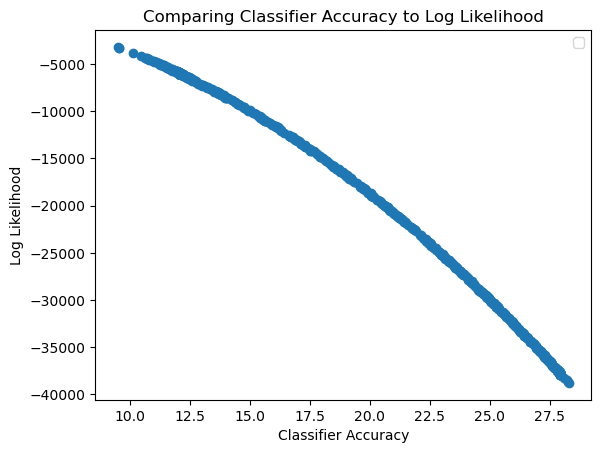

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7f99d2fd7850>

In [269]:
#Plot of Log Likelihood Scores
scores = []
distances = []
ks = []
best_ks = []
best_traces = []
(best_trace,) = generate(classifier, (x,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = Flux.σ.(G(x,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k))
best_dist = euclidean(best_pred_y, y_real)

function likelihood(best_dist, best_score, best_k)
    (trace,) = generate(classifier, (x,), obs)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    #print(k)
    pred_y = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))

    #dist = sqrt(sum((pred_y .- y_real) .^ 2))
    dist = euclidean(pred_y, y_real)
    score = get_score(trace)
    #println(score)
    if dist < best_dist
        best_dist = dist
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
        best_k = best_trace[:k]
    end
    push!(scores,score)
    push!(distances,dist)
    push!(ks, k)
    #println(best_score)
    return(best_dist, best_score, best_k)
end

for i=1:1000
    best_dist, best_score, best_k = likelihood(best_dist, best_score, best_k)
    push!(best_ks, best_k)
end

#for j=1:20
    #new_distances1 = [ks[i] == j ? distances[i] : -1 for i=1:length(distances)]
    #new_distances = filter(x -> x != -1, new_distances1)
    #new_scores1 = [ks[i] == j ? scores[i] : 100 for i=1:length(scores)]
    #new_scores = filter(x -> x < 100, new_scores1)
    #scatter(new_distances,new_scores,label=j)
#end
#plt.xlim(0,200)
#plt.ylim(-6000,0)
scatter(distances, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood")
plt.legend()
#println(best_trace[:k])
#println(best_dist)
#println(best_ks)

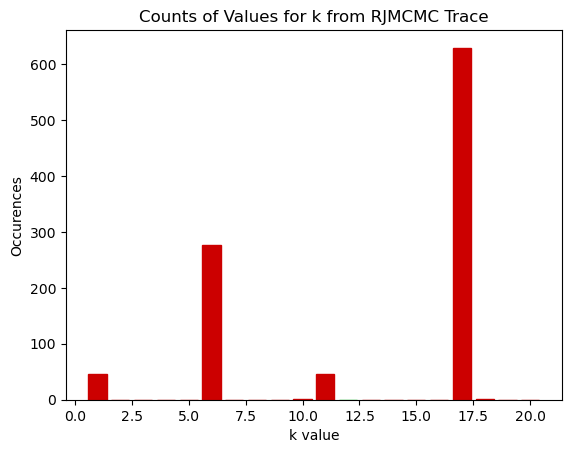

In [270]:
#print(best_ks)
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([best_ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[12].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

In [271]:
#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(trace)
    current_k = trace[:k]
    if current_k == last(k_list)
        new_trace = death(trace)
    elseif current_k == k_list[1]
        new_trace = birth(trace)
    else
        new_trace = bernoulli(0.5) ? birth(trace) : death(trace)
    end
    return new_trace    
end

@gen function birth(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k + 1]
    #new_k = previous_k + 1
    difference = abs(new_k - previous_k)
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_real
    obs_new[:Wₕ] = vcat(Wₕ,[rand(1)[1] for i=1:(2*difference)])
    obs_new[:Wₒ] = vcat(Wₒ,[rand(1)[1] for i=1:difference])
    obs_new[:bₕ] = vcat(bₕ,[rand(1)[1] for i=1:difference])
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (data,), obs_new)
    return new_trace

end

@gen function death(trace)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    previous_k = trace[:k]
    new_k = k_list[previous_k - 1]
    #new_k = previous_k - 1
    difference = abs(previous_k - new_k)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_real
    obs_new[:Wₕ] = Wₕ[1:new_k*2]
    obs_new[:Wₒ] = Wₒ[1:new_k]
    obs_new[:bₕ] = bₕ[1:new_k]
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (data,), obs_new)
    return new_trace
end;

In [284]:
traces = []
acc = []
ks = []

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y_real
obs = obs_master;

function within_dimension(trace, iters)
    for i=1:iters
        (trace, accepted) = hmc(trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=3, eps=0.03, check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
    end
    return trace
end

function across_dimension(trace, iters, obs)
    #selection = select(:Wₕ,:bₕ,:Wₒ,:bₒ,:k)
    #args = get_args(trace)
    #argdiffs = map((_) -> NoChange(), args)
    #(new_trace, weight) = regenerate(trace, args, argdiffs, selection)
    
    new_trace = birth_or_death(trace)
    
    #test = true
    for i=1:3
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=3, eps=0.03, check=false, observations=obs)
        accepted && (test = false)
    end
    #test && println("Nothing accepted")
    
    score1 = exp(get_score(trace)/length(y_real))
    score2 = exp(get_score(new_trace)/length(y_real))
    score = score2/score1
    #println(score1)
    #println(score2)
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:k]
        #println("New k accepted! Current k: $(new_k)")
        push!(acc,true)
    else
        #println("Sticking with the old k!")
        accepted = false
        push!(acc,false)
    end
    
    obs = obs_master
    obs[:k] = trace[:k]
        
    push!(traces, trace)
    push!(acc, accepted)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        #println(trace[:k])
        if i%2000 == 0
            println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
        end
        
        if rand(Uniform(0,1)) > 0.5
            (trace, k) = across_dimension(trace, 1, obs)
        else
            (trace) = within_dimension(trace, 1)
        end
        push!(ks, k)
    end
    println("Finished")
end
 
starting_trace = best_trace
#(starting_trace,) = generate(classifier, (data,), obs)
obs[:k] = starting_trace[:k]
rjmcmc(starting_trace,100000);

Beginning RJMCMC. Starting k: 3
Epoch 2000 Acceptance Prob: 0.6976976976976977
Epoch 4000 Acceptance Prob: 0.6230846102598268
Epoch 6000 Acceptance Prob: 0.5910351714190614
Epoch 8000 Acceptance Prob: 0.5819699499165275
Epoch 10000 Acceptance Prob: 0.579973297730307
Epoch 12000 Acceptance Prob: 0.5732540696705373
Epoch 14000 Acceptance Prob: 0.5689819219790676
Epoch 16000 Acceptance Prob: 0.5635826115922719
Epoch 18000 Acceptance Prob: 0.5578175895765473
Epoch 20000 Acceptance Prob: 0.5522457683593229
Epoch 22000 Acceptance Prob: 0.5487358062074186
Epoch 24000 Acceptance Prob: 0.5390503660971822
Epoch 26000 Acceptance Prob: 0.5300550646689717
Epoch 28000 Acceptance Prob: 0.5265834818775995
Epoch 30000 Acceptance Prob: 0.5237841675541356
Epoch 32000 Acceptance Prob: 0.5170504226173127
Epoch 34000 Acceptance Prob: 0.5153794913992399
Epoch 36000 Acceptance Prob: 0.5136345136345136
Epoch 38000 Acceptance Prob: 0.5099380734347315
Epoch 40000 Acceptance Prob: 0.5086593435900855
Epoch 42000 A

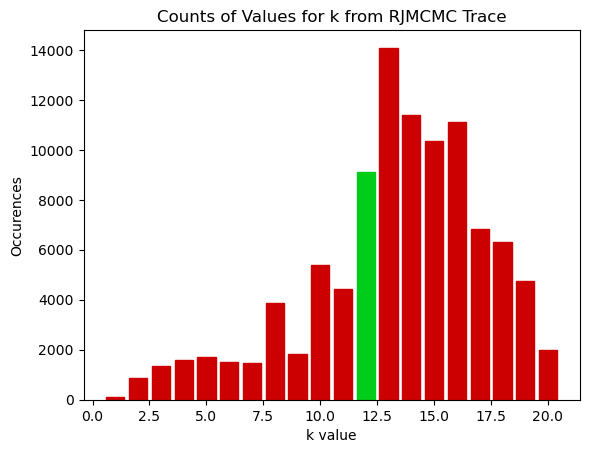

In [285]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[12].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

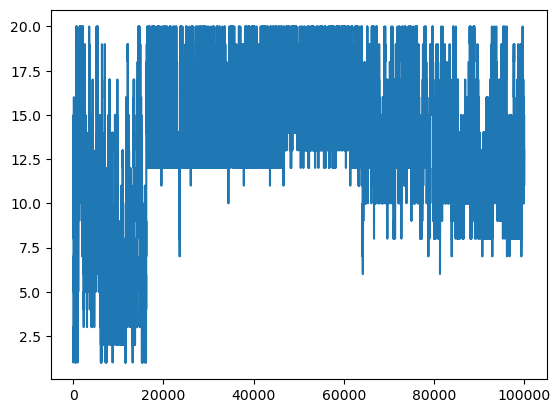

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f99d2a6bad0>

In [286]:
plot(ks)

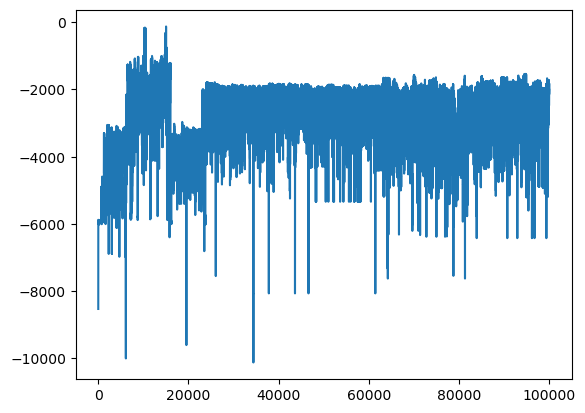

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f99d2a4b810>

In [287]:
scores = [get_score(traces[i]) for i=1:length(traces)]
plot(scores)